# Feature Matching

Feature matching extracts defining key features from an input (using ideas from corner and edge detection). It uses distance calculations and finds matches in a secondary image, therefore we have no need to make copiesof the target image like in ealrier techniques.

Methods under review:
- Brute force matching with ORB descriptors
- Brute force matching with SIFT descriptors and Ratio test
- FLANN based matcher

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

plt.style.use('dark_background')

In [2]:
# Convenience functions 

def show(img, color=True):
    fig = plt.figure(figsize=(16,10))    
    ax = fig.add_subplot(111)
    if color:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap='gray')

def show_two(img1, img2, color=True):
    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    if color:
        ax1.imshow(img1)
        ax2.imshow(img2)
    else:
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')

# Working data

We will use images of a specific cereal box and look for matching in a secon image that contains a typical supermarket aisle with a lot of cereal boxes. You wil see much commonality on the designs that are used.

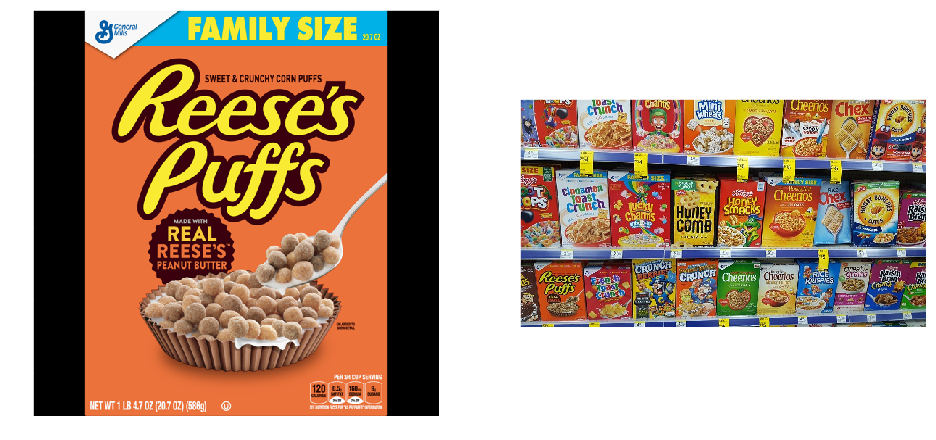

In [37]:
# load the data 
reeses = cv2.imread('DATA/reeses_puffs.png')
cereals = cv2.imread('DATA/many_cereals.jpg')

reeses = cv2.cvtColor(reeses, cv2.COLOR_BGR2RGB)
cereals = cv2.cvtColor(cereals, cv2.COLOR_BGR2RGB)

# use the convenience funtion to check the images 
# are as expected.
show_two(reeses, cereals)

## Brute force with ORB

The sample we are about to see does not work too well for our testcase. The end result will show a subset of all matches and ordered by the closest match. We will see that it does not match them well at all. 

In [38]:
orb = cv2.ORB_create()

In [39]:
# input parameters are the image and a potential mask as we're 
# not using a mask we can pass None as our param. The return is 
# key points and descriptions
kp1, des1 = orb.detectAndCompute(reeses, None)
kp2, des2 = orb.detectAndCompute(cereals, None)

In [40]:
# create the matching objects 
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [41]:
matches = bf.match(des1, des2)

In [42]:
# as an aside lets look at a single match object and check
# the distance where the ruke is the less distance means the 
# closer the match is, a greater distance is a lesser match.
preview_a_single_match = matches[0]
preview_a_single_match.distance

61.0

In [43]:
# for all the match objects - sort in order of distances by 
# passing them through a sorted function that relies upon 
# a lambda to return the distance as the sort key to be used.
matches = sorted(matches, key = lambda x: x.distance)

In [44]:
reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25], None, flags=2)

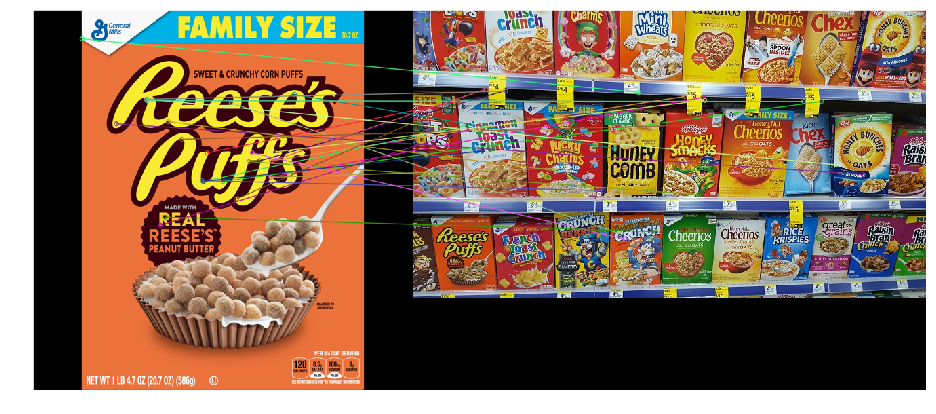

In [45]:
show(reeses_matches, True)

# Brute force with SIFT descriptors

### Scale, Invariant, Feature, Transform

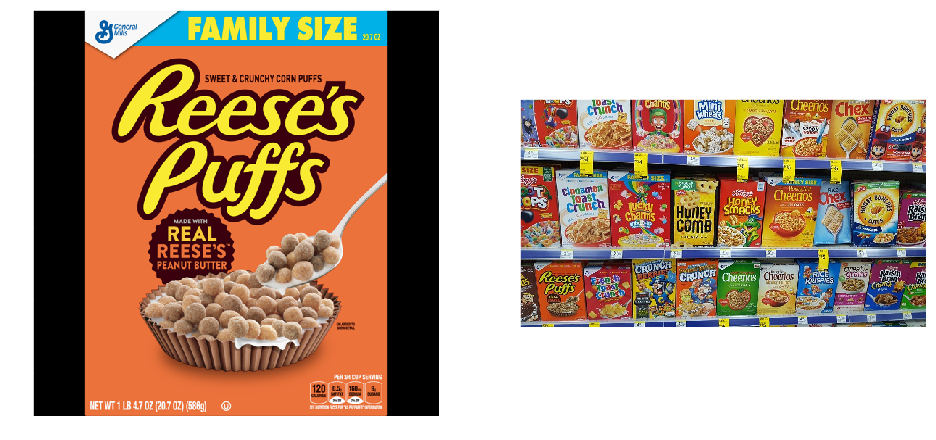

In [29]:
# load the data 
reeses = cv2.imread('DATA/reeses_puffs.png')
cereals = cv2.imread('DATA/many_cereals.jpg')

reeses = cv2.cvtColor(reeses, cv2.COLOR_BGR2RGB)
cereals = cv2.cvtColor(cereals, cv2.COLOR_BGR2RGB)

# use the convenience funtion to check the images 
# are as expected. (using grayscale as no conversion
# has been performed)
show_two(reeses, cereals, False)

In [30]:
sift = cv2.xfeatures2d.SIFT_create()

In [31]:
kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)


In [32]:
bf = cv2.BFMatcher()

In [33]:
# find the k best matches from a descriptor query set, therefpre 
# from the set of des1, des2 we will find the best two matches.
matches = bf.knnMatch(des1, des2, k=2)

### Ratio Test

Next step is to apply a ratio test. A ratio test evaluates the distances of the pair to determine a good match, one strong match can be offset for a poor match on the second descriptor and thus reducing the overall match. 

In [34]:
# Less diatance == better match
# greater distance == poor match 
good = []

# ratio test.
for match1, match2 in matches:
    # check if a good match. 
    # good match is < 75% of second match distance
    if match1.distance < 0.75*match2.distance:
        good.append([match1])
        

In [35]:
print(f"Total matches: {len(matches)} Matches considered as 'good': {len(good)}")

Total matches: 1370 Matches considered as 'good': 53


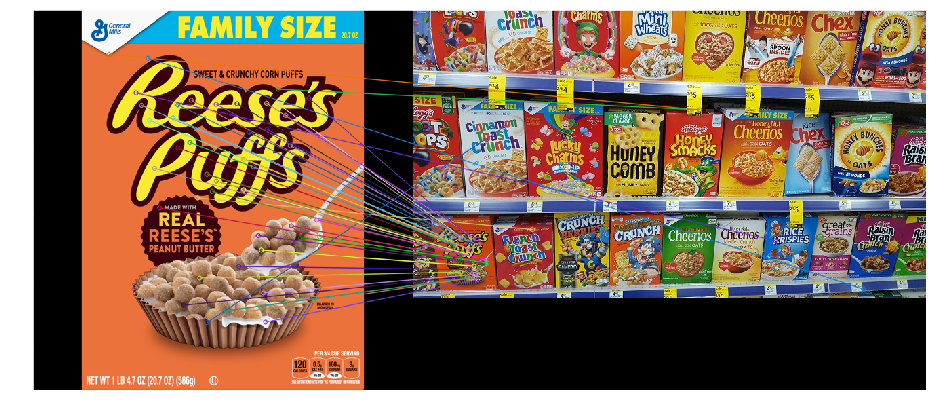

In [36]:
sift_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags=2)
show(sift_matches, True)

# FLANN based matching 

In [67]:
# load the data - useing grayscale
reeses = cv2.imread('DATA/reeses_puffs.png',0)
cereals = cv2.imread('DATA/many_cereals.jpg', 0)


In [68]:
sift = cv2.xfeatures2d.SIFT_create()

In [69]:
kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)

In [70]:
# FLANN Fast Library Approximate nearest neighbours this method is much 
# faster than brue forcig but can be less precise. It will quickly find 
# good matches. Params can be tweaked at the cost of speed. 

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

In [71]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [72]:
matches = flann.knnMatch(des1, des2, k=2)

In [73]:
matches_mask = [[0,0] for i in range(len(matches))]

In [74]:
for i, (match1, match2) in enumerate(matches):
    if match1.distance < 0.75*match2.distance:
        matches_mask[i] = [1,0]
        

In [75]:
draw_params = dict(matchColor=(0,255,0), singlePointColor=(255,0,0), matchesMask=matches_mask, flags=0)

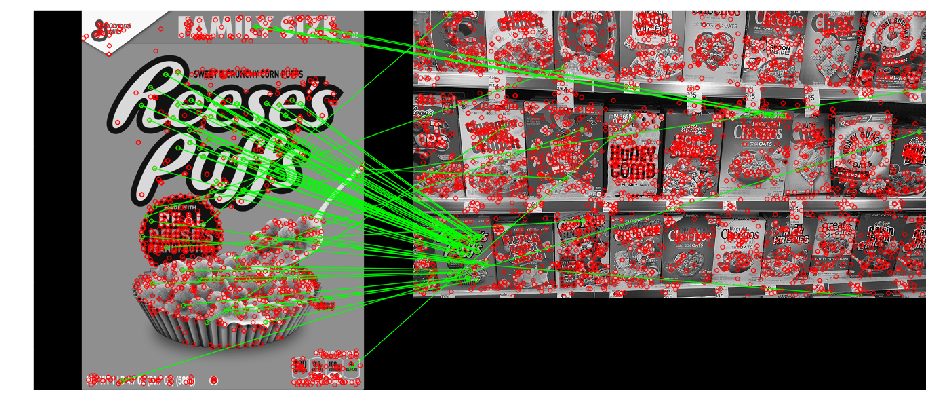

In [76]:
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, matches, None, **draw_params)
show(flann_matches, False)